# Algoritmo de reconhecimento usado KNN

In [ ]:
!pip install opencv-python scikit-learn numpy

## Os códigos seguintes de Knn precisam rodar localmente, pois usam a sua câmera em tempo real para realizar o reconhecimento

## 1° Código

In [ ]:
import cv2
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Função para pré-processar as imagens
def preprocess_image(image_path, target_size=(100, 100)):

    # Redimensiona a imagem e a converte para escala de cinza.

    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, target_size)
    return resized_image.flatten()  # Retorna a imagem como um vetor 1D

# Carregar os dados de treinamento
def load_dataset(data_dir):

    # Carrega as imagens de faces e os rótulos de um diretório de treinamento.

    features = []
    labels = []
    for label in os.listdir(data_dir):  # Cada subpasta é uma classe (nome da pessoa)
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                features.append(preprocess_image(image_path))
                labels.append(label)
    return np.array(features), np.array(labels)

# Configuração dos diretórios
train_dir = "/content/faces/train"  # Diretório de treinamento
test_dir = "/content/faces/test"    # Diretório de teste

# Carregar os dados de treinamento
print("Carregando dados de treinamento...")
X_train, y_train = load_dataset(train_dir)
print(f"Treinamento concluído com {len(X_train)} exemplos.")

# Criar o modelo KNN
print("Treinando o modelo KNN...")
knn = KNeighborsClassifier(n_neighbors=3)  # Usando k = 3. KNeighborsClassifier já possui todo o algoritmo de KNN nele, desde a extração de features, cálculo de distâncias, etc.
knn.fit(X_train, y_train)

# Testar o modelo com imagens desconhecidas
print("Testando o modelo...")
for test_image in os.listdir(test_dir):
    test_image_path = os.path.join(test_dir, test_image)
    test_features = preprocess_image(test_image_path).reshape(1, -1)  # Ajustar para 2D
    predicted_label = knn.predict(test_features)[0]

    # Exibir o resultado
    print(f"Imagem {test_image}: Previsão -> {predicted_label}")
    test_image_raw = cv2.imread(test_image_path)
    cv2.imshow(f"Predição: {predicted_label}", test_image_raw)
    cv2.waitKey(0)

cv2.destroyAllWindows()


#### Crie uma pasta "faces" e coloque dentro dela uma pasta "train" e outra "test". Dentro delas coloque as imagens de treino e a amostra para testar o

## 2° Código

### São 3 arquivos .py.
### O primeiro "facedetect.py" serve para detectar faces e tirar fotos delas.
### O segundo "npwriter.py" serve para salvar as imagens usando numpy num arquivo csv.
### O primeiro "recog.py" serve para reconhecer a face do usuário em tempo real, usando as fotos tiradas no facedetect como base.



In [ ]:
# Arquivo "facedetect.py"
# Este arquivo é usado para detectar rostos e então armazenar os dados do rosto
import cv2
import numpy as np
import npwriter # importa o arquivo onde os dados são armazenados em formato de arquivo CSV
name = input("Digite seu nome: ")

cap = cv2.VideoCapture(0) # Isso é usado para acessar a webcam para capturar os frames
classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml") # Esta é a classe usada para detectar rostos conforme fornecido com o arquivo haarcascade_frontalface_default.xml como dado

f_list = []
while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Converte a imagem para tons de cinza pois é mais fácil para a detecção


    faces = classifier.detectMultiScale(gray, 1.5, 5) # Detecta múltiplas escalas, detecta o rosto e suas coordenadas


    faces = sorted(faces, key=lambda x: x[2]*x[3], # Isso é usado para detectar o rosto que está mais próximo da webcam na primeira posição
            reverse=True)
    faces = faces[:1] # Apenas o primeiro rosto detectado é usado


    if len(faces) == 1: # len(faces) é o número de rostos exibidos em um frame
        face = faces[0] # Isso remove do formato de tupla

        x, y, w, h = face # Armazena as coordenadas do rosto em variáveis diferentes

        im_face = frame[y:y + h, x:x + w]
        cv2.imshow("face", im_face) # Isso irá exibir o rosto que está sendo detectado
        if not ret:
            continue
        cv2.imshow("full", frame)
        key = cv2.waitKey(1)

        # Isso encerrará a execução do programa ao pressionar 'q' e capturará o frame ao pressionar 'c'
        if key & 0xFF == ord('q'):
            break
        elif key & 0xFF == ord('c'):
            if len(faces) == 1:
                gray_face = cv2.cvtColor(im_face, cv2.COLOR_BGR2GRAY)
                gray_face = cv2.resize(gray_face, (100, 100))
                print(len(f_list), type(gray_face), gray_face.shape)

                f_list.append(gray_face.reshape(-1)) # Isso irá adicionar as coordenadas do rosto em f_list
            else:
                print("rosto não encontrado")

            if len(f_list) == 10: # isso armazenará os dados para o rosto detectado 10 vezes para aumentar a precisão
                break

npwriter.write(name, np.array(f_list)) # Declarado no npwriter
cap.release()
cv2.destroyAllWindows()


In [ ]:
# Arquivo "npwriter.py"
import pandas as pd
import numpy as np
import os.path
f_name = "face_data.csv"


def write(name, data): # Armazenando os dados em um arquivo CSV
    if os.path.isfile(f_name):
        df = pd.read_csv(f_name, index_col=0)
        latest = pd.DataFrame(data, columns=map(str, range(10000)))
        latest["name"] = name
        df = pd.concat((df, latest), ignore_index=True, sort=False)
    else:

        df = pd.DataFrame(data, columns=map(str, range(10000))) # Definindo o intervalo apenas porque os dados aqui já estão achatados, como quando foram armazenados em f_list
        df["name"] = name
    df.to_csv(f_name)


In [ ]:
# Arquivo "recog.py"
# Este código é usado para reconhecer o rosto após treinar o modelo com nossos dados armazenados usando KNN
import cv2
import numpy as np
import pandas as pd
import operator
from operator import itemgetter
from npwriter import f_name

def euc_dist(x1, x2): # Função para calcular a distância euclidiana
    return np.sqrt(np.sum((x1 - x2)**2))


class KNN: # Classe KNN (K-Nearest Neighbors)
    def __init__(self, K=4):
        self.K = K

    def fit(self, x_train, y_train):
        self.X_train = x_train
        self.Y_train = y_train

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            dist = np.array([euc_dist(X_test[i], x_t) for x_t in self.X_train])
            dist_sorted = dist.argsort()[:self.K]
            neigh_count = {}
            for idx in dist_sorted:
                if self.Y_train[idx] in neigh_count:
                    neigh_count[self.Y_train[idx]] += 1
                else:
                    neigh_count[self.Y_train[idx]] = 1
            sorted_neigh_count = sorted(neigh_count.items(), key=operator.itemgetter(1), reverse=True)
            predictions.append(sorted_neigh_count[0][0])
        return predictions

data = pd.read_csv(f_name).values # Leitura dos dados


X, Y = data[:, 1:-1], data[:, -1] # Separação dos dados
print(X, Y)


model = KNN(K=5) # Chamando a função KNN com K = 5


model.fit(X, Y) # Treinamento do modelo

cap = cv2.VideoCapture(0)
classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
f_list = []

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = classifier.detectMultiScale(gray, 1.5, 5)
    X_test = []


    for face in faces: # Dados de teste
        x, y, w, h = face
        im_face = gray[y:y + h, x:x + w]
        im_face = cv2.resize(im_face, (100, 100))
        X_test.append(im_face.reshape(-1))

    if len(faces) > 0:

        response = model.predict(np.array(X_test)) # Previsão do resultado usando KNN

        for i, face in enumerate(faces):
            x, y, w, h = face


            cv2.rectangle(frame, (x, y), (x + w, y + h), # Desenhando um retângulo no rosto detectado
                            (255, 0, 0), 3)


            cv2.putText(frame, response[i], (x - 50, y - 50), # Adicionando o nome detectado/predito ao rosto
                        cv2.FONT_HERSHEY_DUPLEX, 2,
                        (0, 255, 0), 3)

    cv2.imshow("full", frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


# Haar Cascade

https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

Link dos modelos de Haar Cascade treinados para detecção de faces

# **ORIENTAÇÃO:**

Ao usar esse colab, você deverá baixar os modelos que você deseja utilizar por meio desse código e adicioná-los nos arquivos usados no notebook. Além disso, deverá ser adicionada a foto que você utilizará para identificar o rosto.


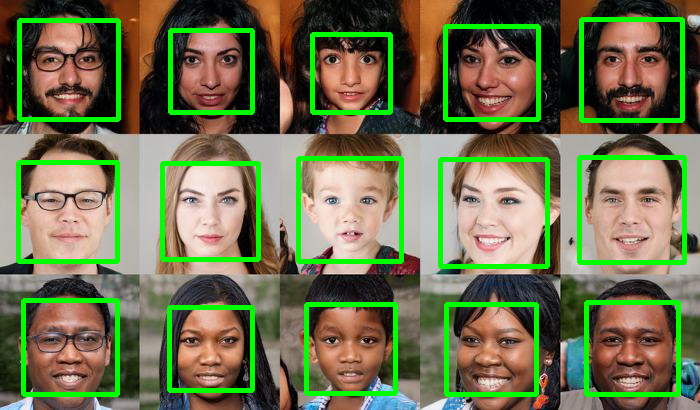

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/foto6.jpg')  #Imagem a ser utilizada
detec = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')  #Modelo a ser utilizado
cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #Tons de cinza para otimizar o processo
face = detec.detectMultiScale(cinza, 1.3, 3)  #Detectar a face
for (x, y, larg, alt) in face:  #Desenhar o retângulo
    ret = cv2.rectangle(img, (x, y), (x + larg, y + alt), (0, 255, 0), 3)
cv2_imshow(img)

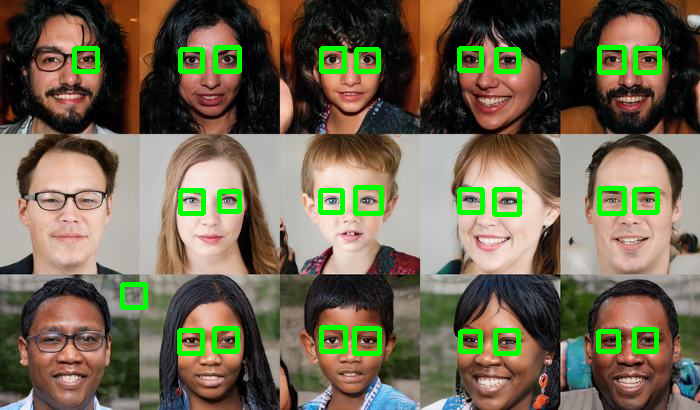

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/foto6.jpg')  #Imagem a ser utilizada
detec = cv2.CascadeClassifier('/content/haarcascade_eye.xml')  #Modelo a ser utilizado
cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #Tons de cinza para otimizar o processo
face = detec.detectMultiScale(cinza, 1.3, 3)  #Detectar a face
for (x, y, larg, alt) in face:  #Desenhar o retângulo
    ret = cv2.rectangle(img, (x, y), (x + larg, y + alt), (0, 255, 0), 3)
cv2_imshow(img)

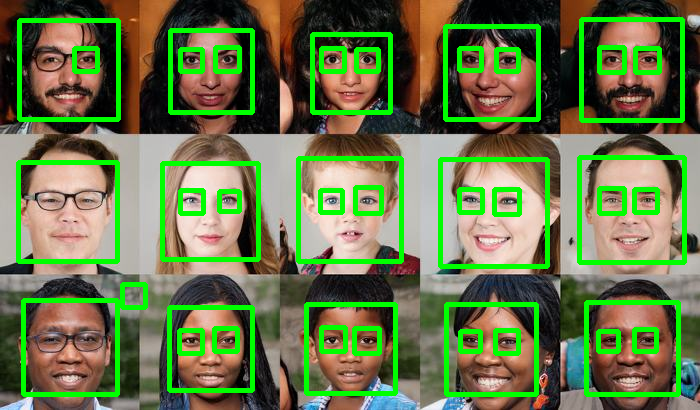

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/foto6.jpg')  #Imagem a ser utilizada
detec = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')  #Modelo a ser utilizado
detec_eyes = cv2.CascadeClassifier('/content/haarcascade_eye.xml')
cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #Tons de cinza para otimizar o processo
face = detec.detectMultiScale(cinza, 1.3, 3)  #Detectar a face
for (x, y, larg, alt) in face:  #Desenhar o retângulo
    ret = cv2.rectangle(img, (x, y), (x + larg, y + alt), (0, 255, 0), 3)

eyes = detec_eyes.detectMultiScale(cinza, 1.3, 3)  #Detectar a face
for (x, y, larg, alt) in eyes:  #Desenhar o retângulo
    ret = cv2.rectangle(img, (x, y), (x + larg, y + alt), (0, 255, 0), 3)
cv2_imshow(img)

#Deep learning

In [ ]:
# Atualiza o sistema e instala dependências
!apt-get update
!apt-get install -y cmake libopenblas-dev liblapack-dev libx11-dev libgtk-3-dev

# Remove dlib e face_recognition para reinstalar corretamente
!pip uninstall -y dlib face_recognition

# Instala a versão correta do dlib com suporte a GPU
!pip install dlib==19.24.2 --force-reinstall --no-binary :all:

# Reinstala o face_recognition
!pip install face_recognition

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,613 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [ ]:
# Passo 1: Instalar dependências
!pip install dlib opencv-python opencv-python-headless numpy

# Passo 2: Baixar os modelos pré-treinados
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!wget http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2

# Descompactar os arquivos
!bzip2 -d mmod_human_face_detector.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2


  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
--2024-11-21 20:09:30--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  2.27MB/s    in 0.3s    

2024-11-21 20:09:30 (2.27 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]

--2024-11-21 20:09:30--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  41.0MB/s    in 1.5s    

2024-11-21 20:09:32 (41.

In [ ]:
# Passo 3: Importar bibliotecas
import dlib
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Passo 4: Carregar modelos
face_detector_model = "mmod_human_face_detector.dat"
landmark_predictor_model = "shape_predictor_68_face_landmarks.dat"
face_recognition_model = "dlib_face_recognition_resnet_model_v1.dat"

detector = dlib.cnn_face_detection_model_v1(face_detector_model)
shape_predictor = dlib.shape_predictor(landmark_predictor_model)
face_recognizer = dlib.face_recognition_model_v1(face_recognition_model)

# Passo 5: Funções auxiliares
def encode_face(image):
    detections = detector(image, 1)
    encodings = []
    for detection in detections:
        rect = detection.rect
        shape = shape_predictor(image, rect)
        encoding = np.array(face_recognizer.compute_face_descriptor(image, shape))
        encodings.append(encoding)
    return encodings

def compare_faces(known_encoding, unknown_encoding, tolerance=0.6):
    distance = np.linalg.norm(known_encoding - unknown_encoding)
    return distance < tolerance

# Passo 6: Carregar imagens
# Suba as imagens para o Colab antes de rodar este bloco
from google.colab import files
print("Envie a imagem conhecida (ex: known_face.jpg):")
known_file = files.upload()

print("Envie a imagem desconhecida (ex: unknown_face.jpg):")
unknown_file = files.upload()

# Carregar as imagens enviadas
known_image_path = list(known_file.keys())[0]
unknown_image_path = list(unknown_file.keys())[0]

image_known = cv2.imread(known_image_path)
image_unknown = cv2.imread(unknown_image_path)

# Converter para escala de cinza (necessário para dlib)
image_known_gray = cv2.cvtColor(image_known, cv2.COLOR_BGR2RGB)
image_unknown_gray = cv2.cvtColor(image_unknown, cv2.COLOR_BGR2RGB)

# Passo 7: Obter vetores de face
known_encodings = encode_face(image_known_gray)
unknown_encodings = encode_face(image_unknown_gray)

# Passo 8: Comparar as faces
if known_encodings and unknown_encodings:
    match = compare_faces(known_encodings[0], unknown_encodings[0])
    print("Faces correspondem!" if match else "Faces NÃO correspondem!")
else:
    print("Nenhuma face detectada em uma das imagens.")

# Exibir as imagens
print("Imagem conhecida:")
cv2_imshow(image_known)

print("Imagem desconhecida:")
cv2_imshow(image_unknown)